# Churn prediction - Waze App

## Step 05 - ML modeling

In this Notebook we will use **tree-based modeling** techniques to predict on a binary target class.

The **purpose** of this model is to find factors that drive user churn.

The **goal** of this model is to predict whether or not a Waze user is retained or churned.


### 1. Imports and Data loading

Packages and libraries to build an evaluate a random forest and XGBoost classification model:

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from xgboost import plot_importance
import pickle

In [ ]:
df0 = pd.read_csv('waze_dataset.csv')

df = df0.copy()

df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


### 2. Data cleaning

In [ ]:
# Drop rows with missing values
df = df.dropna(subset=['label'])

# Drop 'ID' column
df = df.drop(['ID'], axis=1)

### 3. Feature engineering

We already prepared the data and performed EDA in previous notebooks.

Here we will use the prepared feautures and engineer new features to use for modeling.

#### 'km_per_driving_day'

This feauture represents the mean number of kilometers driven on each driving day in the last month for each user.

As we noticed in the previous notebook, some descriptive statistics values are infinite. This is the result of there being values of zero in the 'driving_days' column. <br>
We will convert these values from infinity to zero.

In [ ]:
# Create 'km_per_driving_day' feature
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# Descriptive statistics
df['km_per_driving_day'].describe()

,km_per_driving_day
count,1.429900e+04
mean,inf
std,NaN
min,3.022063e+00
25%,1.675616e+02
50%,3.241789e+02
75%,7.608293e+02
max,inf


In [ ]:
# Convert infinite values to zero
df.loc[df['km_per_driving_day'] == np.inf, 'km_per_driving_day'] = 0

# Confirm that it worked
df['km_per_driving_day'].describe()

,km_per_driving_day
count,14299.000000
mean,581.942399
std,1038.254509
min,0.000000
25%,136.168003
50%,273.301012
75%,558.018761
max,15420.234110


#### 'percent_sessions_in_last_month'

We create a new column 'percent_sessions_in_last_month' that represents the percentage of each user's total sessions that were logged in their last month of use.

In [ ]:
# Create 'percent_sessions_in_last_month' feature
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

# Descriptive stats
df['percent_sessions_in_last_month'].describe()

,percent_sessions_in_last_month
count,14299.000000
mean,0.449837
std,0.286863
min,0.000000
25%,0.196890
50%,0.424310
75%,0.687251
max,1.530637


#### 'professional_driver'

We create a new, binary feature called professional_driver that is a 1 for users who had 60 or more drives and drove on 15+ days in the last month.

In [ ]:
# Create 'total_sessions_per_day' feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

# Descriptive stats
df['total_sessions_per_day'].describe()

,total_sessions_per_day
count,14299.000000
mean,0.338207
std,1.319814
min,0.000298
25%,0.050818
50%,0.100457
75%,0.215210
max,39.763874


#### 'km_per_drive'

We create a column representing the mean number of kilometers per drive made in the last month for each user.

In [ ]:
# Create 'km_per_drive' feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']

# Descriptive stats
df['km_per_drive'].describe()

,km_per_drive
count,1.429900e+04
mean,inf
std,NaN
min,1.008775e+00
25%,3.325389e+01
50%,7.490594e+01
75%,1.854667e+02
max,inf


In [ ]:
# Convert infinite values to zero
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0

# Confirm that it worked
df['km_per_drive'].describe()

,km_per_drive
count,14299.000000
mean,232.269197
std,616.197409
min,0.000000
25%,32.486524
50%,72.947059
75%,179.347527
max,15777.426560


#### 'percent_of_sessions_to_favorite'

Finally, we create a new column that represents the percentage of total sessions that were used to navigate to one of the users' favorite places.

In [ ]:
# Create 'percent_of_sessions_to_favorite' feature
df['percent_of_drives_to_favorite'] = (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Descriptive stats
df['percent_of_drives_to_favorite'].describe()

,percent_of_drives_to_favorite
count,14299.000000
mean,1.676347
std,9.021250
min,0.000000
25%,0.206064
50%,0.653572
75%,1.643183
max,777.563629


### 4. Variable encoding

In order to use categorical variables as an X variable, we will need to convert them to binary.

In [ ]:
# Create new 'device_binary' variable
df['device_binary'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device_binary']].tail()

,device,device_binary
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


In [ ]:
# Create binary 'label_binary' column
df['label_binary'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label_binary']].tail()

,label,label_binary
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


### 5. Model building - Random Forest

#### Split data


In [ ]:
# Isolate X variables
X = df.drop(columns=['label', 'label_binary', 'device'])

# Isolate y variable
y = df['label_binary']

# Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr, test_size=0.25, random_state=42)

#### Modeling

In [ ]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }

# 3. Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [ ]:
#Fit the model
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

#### Examination

In [ ]:
# Examine best score
rf_cv.best_score_

# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

We use the following 'make_results()' function to output all of the scores of the model

In [ ]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [ ]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.463889,0.124815,0.196506,0.81921


**Conclusion:** <br>
Asside from the accuracy, the scores aren't that good. However, we recall that when we built the logistic regression model in the last notebook the recall was ~0.09, which means that this model has 33% better recall and about the same accuracy, and it was trained on less data.

### 6. Model building - XGBoost

#### Modeling

We try to improve the scores by using a XGBoost model.

In [ ]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# 3. Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [ ]:
#Fit the model
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

#### Examination

In [ ]:
# Examine best score
xgb_cv.best_score_

# Examine best hyperparameter combo
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 300}

In [ ]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.463889,0.124815,0.196506,0.819210
0,XGB cv,0.402713,0.162282,0.231223,0.808602


**Conclusion:** <br>
This model fit the data even better than the random forest model. The recall score is nearly double the recall score from the logistic regression model from the previous notebook, and it's almost 50% better than the random forest model's recall score, while maintaining a similar accuracy and precision score.

### 7. Model selection

Now, we use the best random forest model and the best XGBoost model to predict on the validation data. Whichever performs better will be selected as the champion model.

To compare the results we define a 'get_test_scores()' function to generate a table of scores from the predictions of the validation data

In [ ]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

#### Random Forest

In [ ]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

# Get validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.463889,0.124815,0.196506,0.819210
0,XGB cv,0.402713,0.162282,0.231223,0.808602
0,RF val,0.439716,0.122288,0.191358,0.816783


#### XGBoost

In [ ]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.463889,0.124815,0.196506,0.819210
0,XGB cv,0.402713,0.162282,0.231223,0.808602
0,RF val,0.439716,0.122288,0.191358,0.816783
0,XGB val,0.379147,0.157791,0.222841,0.804895


#### Conclusion

Just like the random forest model, the XGBoost model's validation scores were lower than the training scores. This means both models did not overfit the training data.

Overall, the XGBoost model is the clear champion.

### 8. Predict on test data

We use the champion model to predict on the test data. This is to give a final indication of how we should expect the model to perform on new feature data.

In [ ]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.463889,0.124815,0.196506,0.819210
0,XGB cv,0.402713,0.162282,0.231223,0.808602
0,RF val,0.439716,0.122288,0.191358,0.816783
0,XGB val,0.379147,0.157791,0.222841,0.804895
0,XGB test,0.389344,0.187377,0.252996,0.803846


Conclusion: <br>
The recall was exactly the same as it was on the validation data, but the precision declined notably, which caused all of the other scores to drop slightly. Nonetheless, this is stil within the acceptable range for performance discrepancy between validation and test scores

#### Cofusion Matrix

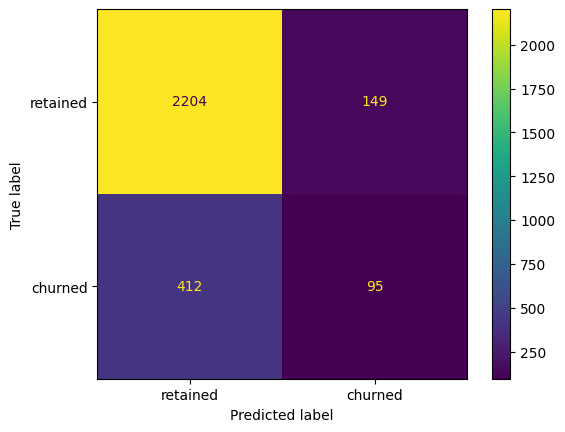

In [ ]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

The model predicted over three times as many false negatives than it did false positives, and it correctly identified only 18.1% of the users who actually churnedThe model predicted over three times as many false negatives than it did false positives, and it correctly identified only 18.1% of the users who actually churned.

#### Feature importance

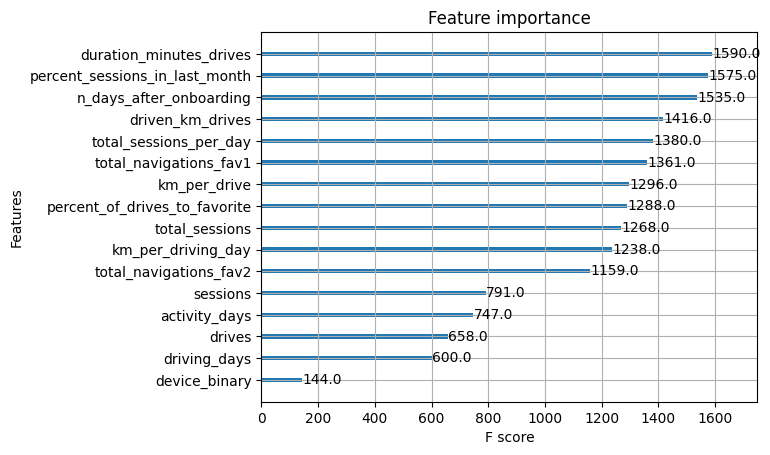

In [ ]:
plot_importance(xgb_cv.best_estimator_);

### 9. Conclusion

- The model is not a strong enough predictor, as made clear by its poor recall score. However, if the model is only being used to guide further exploratory efforts, then it can have value.

- The engineered features made up over half of the top 10 most-predictive features used by the model. It could also be helpful to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features.

- It would be helpful to have drive-level information for each user (such as drive times, geographic locations, etc.). It would probably also be helpful to have more granular data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Finally, it could be helpful to know the monthly count of unique starting and ending locations each driver inputs.